In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from typing import Set, List, Iterable
import collections
import itertools
from numpy.random import default_rng
import numpy as np
import random
import sys
from pathlib import Path
import re
import pandas as pd
from pympler.asizeof import asizeof
from humanize.filesize import naturalsize
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
import lshexp.minhash as mh
from lshexp import shingle

<IPython.core.display.Javascript object>

In [5]:
def words_of_wiki_articles(pattern):
    words = set()
    split_reg = re.compile("\W")
    for p in Path("./data/wikipediaArticles").glob(pattern):
        with p.open("r") as f:
            for l in f.readlines():
                l = l.strip()
                if l and not l.lstrip().startswith("#"):
                    words = words.union(
                        l.strip().lower() for l in split_reg.split(l) if l.strip()
                    )
    return words

<IPython.core.display.Javascript object>

In [11]:
words = list(words_of_wiki_articles("en*.txt"))
len(words), words[:4]

(10892, ['tremors', 'jansenism', 'april', 'massemorderne'])

<IPython.core.display.Javascript object>

In [18]:
random.seed(42)
documents = [
    " ".join(random.choices(words, k=n_words))
    for _ in range(5000)
    for n_words in range(1, 9)
]
len(documents), naturalsize(asizeof(documents)), documents[20:25]

(40000,
 '3.9 MB',
 ['clash gazette criticism immense materiel',
  'recent cells close line suspended toots',
  'guided cappelen row newspaper pansexual zimbabwean plumes',
  'frenchconseiller overall jurisdiction voting rose trinity taraqqi renomination',
  'ivens'])

<IPython.core.display.Javascript object>

In [21]:
%%time

from lshexp import shingle

shingles = [shingle.all_ngrams(s, 5) for s in documents]
len(shingles), shingles[:2]

CPU times: user 868 ms, sys: 93.2 ms, total: 962 ms
Wall time: 966 ms


(40000,
 [{'$$$$s',
   '$$$si',
   '$$sim',
   '$simi',
   'ar$$$',
   'ilar$',
   'imila',
   'lar$$',
   'milar',
   'r$$$$',
   'simil'},
  {' usa$',
   '$$$$p',
   '$$$pr',
   '$$pre',
   '$pres',
   'a$$$$',
   'an us',
   'byter',
   'erian',
   'esbyt',
   'ian u',
   'n usa',
   'presb',
   'resby',
   'rian ',
   'sa$$$',
   'sbyte',
   'teria',
   'usa$$',
   'yteri'}])

<IPython.core.display.Javascript object>

In [22]:
train = shingles[:5000]

<IPython.core.display.Javascript object>

In [23]:
from datasketch import MinHashLSH, MinHash
import murmurhash.mrmr

<IPython.core.display.Javascript object>

## Default datasketch LSH

In [123]:
j_threshold = 0.6

<IPython.core.display.Javascript object>

In [124]:
%%time
n_hashes = 64

def datasketch_minhash(shingles: List[str]):
    m = MinHash(n_hashes)
    m.update_batch([s.encode("utf8") for s in shingles])
    return m

lsh_datasketch_default = MinHashLSH(threshold=j_threshold, num_perm=n_hashes)
for i, row_shingles in enumerate(train):
    lsh_datasketch_default.insert(i, datasketch_minhash(row_shingles))
    
naturalsize(asizeof(lsh_datasketch_default))

CPU times: user 8.13 s, sys: 43.2 ms, total: 8.18 s
Wall time: 8.19 s


'17.7 MB'

<IPython.core.display.Javascript object>

## Datasketch with hash function for LSH

In [125]:
%%time
hashfunc=murmurhash.mrmr.hash

lsh_datasketch_murmur = MinHashLSH(threshold=j_threshold, num_perm=n_hashes, hashfunc=hashfunc)
for i, row_shingles in enumerate(train):
    lsh_datasketch_murmur.insert(i, datasketch_minhash(row_shingles))
    
naturalsize(asizeof(lsh_datasketch_murmur))

CPU times: user 8.33 s, sys: 39.8 ms, total: 8.37 s
Wall time: 8.41 s


'14.9 MB'

<IPython.core.display.Javascript object>

In [126]:
len(lsh_datasketch_murmur.hashtables)

10

<IPython.core.display.Javascript object>

## Own LSH

In [127]:
from lshexp import minhash as mh

lsh_lshexp = mh.LSH(n_hashes=n_hashes, bands=lsh_datasketch_murmur.b)
minhash_lshexp = mh.make_minhash_generator(n_hashes=n_hashes)


def lsh_lshexp_minhash(shingles: List[str]):
    return minhash_lshexp(shingles)
    return datasketch_minhash(shingles).hashvalues

<IPython.core.display.Javascript object>

In [91]:
print(mh.hash32(b"askjdfklj"))
print(type(mh.hash32(b"askjdfklj")))
d = [b.encode("utf-8") for b in documents[:1000]]
print(min(map(mh.hash32, d)))
%timeit list(map(mh.hash32, d))

2278732690
<class 'int'>
493516
658 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<IPython.core.display.Javascript object>

In [111]:
%timeit minhash_lshexp(train[0])

590 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<IPython.core.display.Javascript object>

In [72]:
%timeit datasketch_minhash(train[0]).hashvalues

1.26 ms ± 5.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<IPython.core.display.Javascript object>

In [128]:
%%time

for i, row_shingles in enumerate(train):
    lsh_lshexp.insert(lsh_lshexp_minhash(row_shingles), i)
    
naturalsize(asizeof(lsh_lshexp))

CPU times: user 4.42 s, sys: 3.27 ms, total: 4.42 s
Wall time: 4.44 s


'14.2 MB'

<IPython.core.display.Javascript object>

## Testing the LSHs

- precision
- recall
- plot jaccard-similarity -> probability to become candidate
- storage size
- indexing time
- lookup time

In [129]:
df = pd.DataFrame(
    dict(
        documents=documents,
        shingles=shingles,
    )
)
df_train = df.loc[: len(train)]
df_test = df.iloc[len(train) :].drop_duplicates(subset=["documents"])

len(df_train), naturalsize(asizeof(df_train)), len(df_test), naturalsize(
    asizeof(df_test)
)

(5001, '192.7 MB', 34234, '150.4 MB')

<IPython.core.display.Javascript object>

In [131]:
%%time
import lshexp.metrics

def calculate_precision(
    shingle_series, shingle_series_train, lsh_query_fn, jaccard_threshold
):
    results = shingle_series.apply(lsh_query_fn)
    #     results = candidates.loc[candidates.apply(bool)]
    n_correct = 0
    n_total = 0
    for left_shingles, candidate_list in zip(shingle_series, results):
        n_total += len(candidate_list)
        for c in candidate_list:
            right_shingles = shingle_series_train[c]
            j = lshexp.metrics.jaccard_similarity(left_shingles, right_shingles)
            if j >= jaccard_threshold:
                n_correct += 1
    if n_total == 0:
        return 1.0, 0
    return n_correct/n_total, n_total

chunk_size = 500
precisions = []
for start_index in range(0, min(len(df_test), 2000), chunk_size):
    precision = {
        name: calculate_precision(
            df_test["shingles"][start_index:start_index+chunk_size],
            df_train["shingles"],
            query_fn,
            j_threshold,
        )
        for name, query_fn in [
            (
                "lsh_datasketch_default",
                lambda s: lsh_datasketch_default.query(datasketch_minhash(s)),
            ),
            (
                "lsh_datasketch_murmur",
                lambda s: lsh_datasketch_murmur.query(datasketch_minhash(s)),
            ),
            ("lsh_lshexp", lambda s: lsh_lshexp.query(lsh_lshexp_minhash(s))),
        ]
    }
    print(start_index, precision)
    precisions.append(
        {"precision_"+key: v[0] for key, v in precision.items()} |
        {"support_"+key: v[1] for key, v in precision.items()} 
    )
pd.DataFrame.from_records(precisions).describe()

0 {'lsh_datasketch_default': (0.6666666666666666, 3), 'lsh_datasketch_murmur': (0.6666666666666666, 3), 'lsh_lshexp': (0.6666666666666666, 3)}
500 {'lsh_datasketch_default': (0.8571428571428571, 7), 'lsh_datasketch_murmur': (0.8571428571428571, 7), 'lsh_lshexp': (0.75, 8)}
1000 {'lsh_datasketch_default': (0.25, 4), 'lsh_datasketch_murmur': (0.25, 4), 'lsh_lshexp': (0.5, 2)}
1500 {'lsh_datasketch_default': (0.8, 5), 'lsh_datasketch_murmur': (0.8, 5), 'lsh_lshexp': (1.0, 4)}
CPU times: user 6.99 s, sys: 10 ms, total: 7 s
Wall time: 7.01 s


,precision_lsh_datasketch_default,precision_lsh_datasketch_murmur,precision_lsh_lshexp,support_lsh_datasketch_default,support_lsh_datasketch_murmur,support_lsh_lshexp
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.643452,0.643452,0.729167,4.750000,4.750000,4.250000
std,0.274174,0.274174,0.208333,1.707825,1.707825,2.629956
min,0.250000,0.250000,0.500000,3.000000,3.000000,2.000000
25%,0.562500,0.562500,0.625000,3.750000,3.750000,2.750000
50%,0.733333,0.733333,0.708333,4.500000,4.500000,3.500000
75%,0.814286,0.814286,0.812500,5.500000,5.500000,5.000000
max,0.857143,0.857143,1.000000,7.000000,7.000000,8.000000


<IPython.core.display.Javascript object>

/home/christian/.cache/pypoetry/virtualenvs/lsh-experiments-Ll1AlaQ1-py3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


20 rounds, 0 samples, 0 thereof < 1
CPU times: user 12 s, sys: 26.3 ms, total: 12 s
Wall time: 12 s


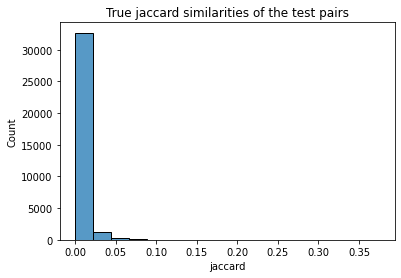

<IPython.core.display.Javascript object>

In [132]:
%%time
import lshexp.metrics


def add_train_samples_with_jaccard(df, train: pd.DataFrame, threshold):
    zeroes = df["jaccard"] < threshold
    samples = train.sample(sum(zeroes), replace=True)
    samples = samples.assign(index_y=list(samples.index)).set_index(
        zeroes.loc[zeroes].index.values
    )
    df["documents_y"].loc[zeroes] = samples["documents"]
    df["shingles_y"].loc[zeroes] = samples["shingles"]
    df["index_y"].loc[zeroes] = samples["index_y"]
    df["jaccard"].loc[zeroes] = (
        df[["shingles", "shingles_y"]]
        .loc[zeroes]
        .apply(lambda row: lshexp.metrics.jaccard_similarity(*row), axis=1, raw=True)
    )

# df_test = df_test.merge(
#     df_train.sample(len(df_test), replace=True).set_index(df_test.index.values),
#     left_index=True,
#     right_index=True,
#     suffixes=["", "_y"],
# )
df_test = df_test.assign(documents_y=None, shingles_y=None, index_y=0, jaccard=0.0)
# df_test["jaccard"] = df_test[["shingles", "shingles_y"]].apply(
#     lambda row: lshexp.metrics.jaccard_similarity(*row), axis=1, raw=True
# )
i = 0
while (df_test["jaccard"] < j_threshold).sum() > 0.1 * len(df_test) and i < 20:
    add_train_samples_with_jaccard(df_test, df_train, j_threshold)
    i += 1
samples_found = (df_test["jaccard"] >= j_threshold).sum()
print(i, "rounds,", samples_found, "samples,", samples_found - (df_test["jaccard"] >= 0.9999).sum(), "thereof < 1")


ax = sns.histplot(data=df_test["jaccard"])
_ = ax.set_title("True jaccard similarities of the test pairs")

In [68]:
%%time
def calculate_recall(df, lsh_query_fn):
    return (
        df.assign(candidates=df["shingles"].apply(lsh_query_fn))[
            ["index_y", "candidates"]
        ]
        .apply(
            lambda row: str(row[0]) in set(str(c) for c in row[1]),
            raw=True,
            axis=1,
        )
        .mean()
    )


df_recall_test = df_test.loc[df_test["jaccard"] >= j_threshold]

recall = {
    name: calculate_recall(df_recall_test, query_fn)
    for name, query_fn in [
        (
            "lsh_datasketch_default",
            lambda s: lsh_datasketch_default.query(datasketch_minhash(s)),
        ),
        (
            "lsh_datasketch_murmur",
            lambda s: lsh_datasketch_murmur.query(datasketch_minhash(s)),
        ),
        ("lsh_lshexp", lambda s: lsh_lshexp.query(lsh_lshexp_minhash(s))),
    ]
}
recall

CPU times: user 38.9 ms, sys: 6 µs, total: 38.9 ms
Wall time: 36.4 ms


{'lsh_datasketch_default': 1.0,
 'lsh_datasketch_murmur': 1.0,
 'lsh_lshexp': 1.0}

<IPython.core.display.Javascript object>

In [ ]:

#%%

def jaccard_similarity(s1: Set, s2: Set):
    return len(s1.intersection(s2)) / len(s1.union(s2))

def count_equal(l1: List, l2: List):
    return sum(a == b for a, b in zip(l1, l2))

#%% md

## Create shingles of example documents

#%%

documents = [
    "Fritz-Haber-Weg 15",
    "Fritz-Haber-Straße 15",
    "Fritz-Haber-Str. 15",
    "Pützchenweg 23",
]
for d in documents:
    print(sorted(shingles(d)))

document_shingles = [shingles(d) for d in documents]
for d1 in document_shingles:
    similarities = [jaccard_similarity(d1, d2) for d2 in document_shingles]
    print(similarities)

all_shingles = list(set.union(*document_shingles))

#%% md

## Approach 3.3.2: Min index of all_shingles permutation

#%%

n_permutations = 50
minhashes = []  # [0 for _ in range(len(document_shingles))]
for d in document_shingles:
    doc_minhash = []
    for p in set_permutations(all_shingles, n_permutations):
        for i, shingle in enumerate(p):
            if shingle in d:
                doc_minhash.append(i)
                break
    minhashes.append(doc_minhash)

#%%

for i, (mh1, sh1) in enumerate(zip(minhashes, document_shingles)):
    for j, (mh2, sh2) in enumerate(zip(minhashes, document_shingles)):
        print(f"{i} => {j} Real jaccard: {jaccard_similarity(sh1, sh2):.2f} Estimated: {count_equal(mh1, mh2) / len(mh1):.2f}")

#%% md

## Approach 3.3.4 Minhash

#%%

import hashlib
import struct

def hash32(data):
    """A 32-bit hash function based on SHA1."""
    return struct.unpack('<I', hashlib.sha1(data).digest()[:4])[0]

#%%

_mersenne_prime = np.uint64((1 << 61) - 1)
n_hashes = 100
random.seed(42)
params = [(random.randint(0, _mersenne_prime), random.randint(0, _mersenne_prime)) for _ in range(n_hashes)]
# print(params)

def calc_minhashes(shingles: List[str]) -> np.array:
    hashes = np.array([hash32(s.encode("utf-8")) for s in shingles])
    hashes = np.array([
        (a*hashes + b) % _mersenne_prime for a, b in params
    ])
    minhashes = np.min(hashes, axis=1)
    return minhashes

#%%

minhashes = [calc_minhashes(ds) for ds in document_shingles]

for i, (mh1, sh1) in enumerate(zip(minhashes, document_shingles)):
    for j, (mh2, sh2) in enumerate(zip(minhashes, document_shingles)):
        print(f"{i} => {j} Real jaccard: {jaccard_similarity(sh1, sh2):.2f} Estimated: {count_equal(mh1, mh2) / len(mh1):.2f}")

#%% md

## LSH

#%%

j_threshold = 0.6



minhashes = [calc_minhashes(ds) for ds in document_shingles]
lsh = LSH(n_hashes=len(minhashes[0]))

for minh, doc in zip(minhashes, documents):
    lsh.insert(minh, doc)

for i, d in enumerate(documents):
    print(d, lsh.query(minhashes[i]))


#%%
from pympler.asizeof import asizeof
asizeof(lsh.bands)

#%%
b = LSH._hash(np.array([1,2,4]))
print(b)
np.array(struct.unpack(3*"I", b)).byteswap()

#%% md

## stuff from the book

#%%

h1 = np.array([1,2,3,4,0])
h2 = np.array([1,4,2,0,3])
S = [
    np.array([1,0,0,1,0]),
    np.array([0,0,1,0,0]),
    np.array([0,1,0,1,1]),
    np.array([1,0,1,1,0])
]

S[0], h1


#%%

minhashes = []
for h in (h1, h2):
    minhashes.append([np.min(np.where(s, h, np.inf)) for s in S])
minhashes = np.array(minhashes).T
minhashes

#%%

for i, s1 in enumerate(S):
    for j, s2 in enumerate(S):
        jaccard = np.sum(s1 & s2) / np.sum(s1 | s2)
        estimated_jaccard = sum(np.equal(minhashes[i], minhashes[j])) / len(minhashes[0])
        print(f"{i} => {j} Real jaccard: {jaccard:.2f} Estimated: {estimated_jaccard:.2f}")

#%%



#%%


